# Loading libraries

In [ ]:
def load_dataset_from_drive():
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/datasets/CamVid'
    return dataset_path

DATASET_PATH = load_dataset_from_drive()

Mounted at /content/drive


In [ ]:
pip install torchviz

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models import resnet50
import torchvision.models.segmentation as segmentation
from torchviz import make_dot
from torch.autograd import Variable
from sklearn.metrics import jaccard_score
from tqdm import tqdm


# Setting device

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preperation

In [ ]:
import pandas as pd

def load_color_mapping(csv_path):
    # Load the CSV file
    df = pd.read_csv(csv_path)
    # Create a mapping from (r, g, b) to the class index
    color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()}
    return color_mapping,df


In [ ]:
color_mapping,df=load_color_mapping("/content/drive/My Drive/datasets/CamVid/class_dict.csv")
print(color_mapping)

{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}


## Custom Dataset class

In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = cv2.imread(self.label_files[idx]) # Load as RGB
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        #Convert the RGB label to class indices
        label = self.convert_rgb_to_class(label)
#         Apply transformations, if any
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label.long()

    def convert_rgb_to_class(self, label):
        """Convert RGB mask to class indices."""
        # Create an empty mask with the same shape as the label
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=int)

        # Iterate over each pixel and assign the class index based on RGB value
        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask


## Data augmentation

In [ ]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(400, 520),
            A.RandomCrop(height=352, width=480),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.GaussianBlur(blur_limit=(3, 5), p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(352, 480),
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])


In [ ]:
# Instantiate datasets with the color map
train_dataset = CamVidDataset('/content/drive/My Drive/datasets/CamVid/train', '/content/drive/My Drive/datasets/CamVid/train_labels', color_mapping, transform=get_transforms(train=True))
val_dataset = CamVidDataset('/content/drive/My Drive/datasets//CamVid/val', '/content/drive/My Drive/datasets/CamVid/val_labels', color_mapping, transform=get_transforms(train=False))
test_dataset = CamVidDataset('/content/drive/My Drive/datasets//CamVid/test', '/content/drive/My Drive/datasets//CamVid/test_labels', color_mapping, transform=get_transforms(train=False))

## visualizing few input and label images

In [ ]:
import matplotlib.pyplot as plt


def visualize_samples(dataset, color_mapping, num_samples=3):
    # Create a reverse mapping from class index to RGB values for visualization
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        # Get a sample from the dataset
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        label = label.numpy()


        # Create an RGB mask for visualization
        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label == class_idx] = rgb

        # Plot the image and label
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Label')
        axs[i, 1].axis('off')


    plt.tight_layout()
    plt.show()


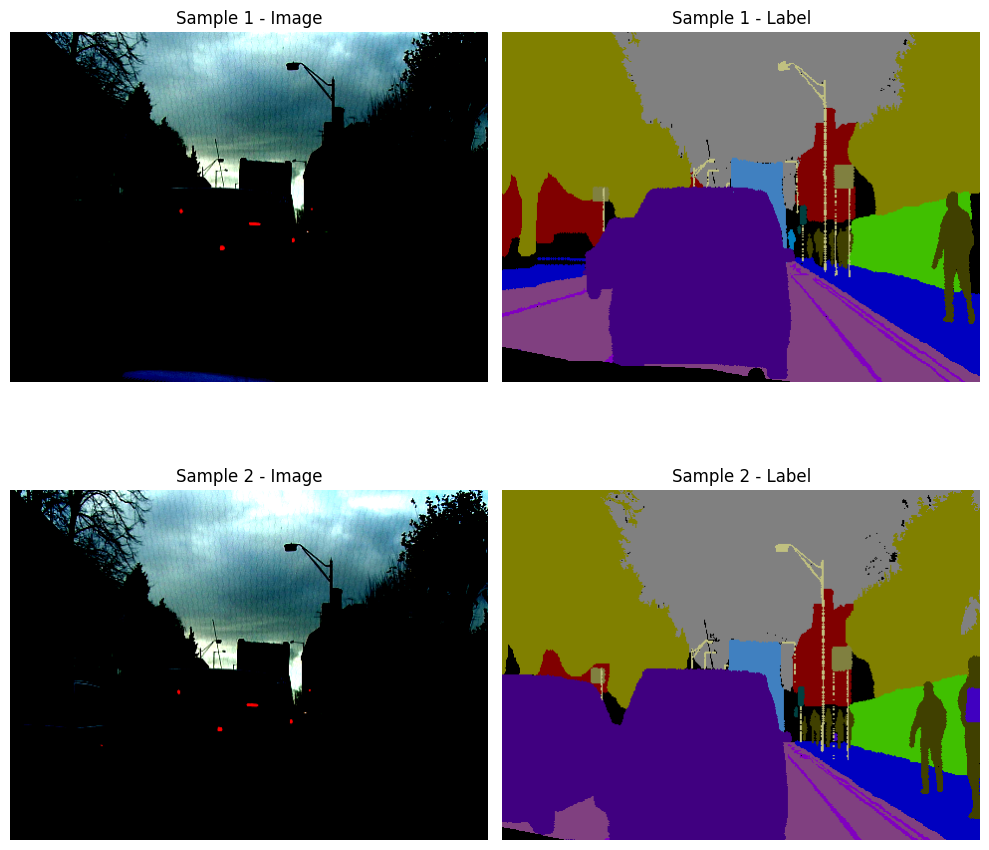

In [ ]:
visualize_samples(train_dataset,color_mapping, num_samples=2)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
# check shape of image and label
for i, (image, mask) in enumerate(train_loader):
    print(f"Batch {i}: Image shape: {image.shape}, Mask shape: {mask.shape}")
    break


Batch 0: Image shape: torch.Size([4, 3, 352, 480]), Mask shape: torch.Size([4, 352, 480])


# Implementing the Fully Convolutional Network (FCN) -- Scratch

In [ ]:
class FCNSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(FCNSegmentation, self).__init__()

        # ResNet-50 as encoder backbone
        resnet = models.resnet50(pretrained=True)

        # Encoder using ResNet50 layers, excluding the fully connected part
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Decoder for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Upsample(size=(352, 480), mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Visualize model architecture

In [ ]:
!pip install torchviz

# Training

## callbacks(early stopping)

In [ ]:
import torch.optim as optim
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# loss function combined (dice + jaccard )

In [ ]:
# dice loss

def dice_loss(pred, target, smooth=1e-6):
    # Convert target to one-hot encoding
    # target shape: (batch_size, height, width) -> (batch_size, num_classes, height, width)
    target = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    pred = pred.contiguous()
    target = target.contiguous()

    # Compute Dice loss
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) /
                (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))

    # Average loss across all classes
    return loss.mean()

# Jaccard Loss

class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Convert y_true to one-hot encoding (assumed input as (batch_size, height, width))
        y_true = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2).float()

        # Apply sigmoid to y_pred for binary/multiclass segmentation if necessary
        y_pred = torch.sigmoid(y_pred)

        # Flatten the tensors
        y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
        y_true = y_true.contiguous().view(y_true.shape[0], -1)

        # Compute intersection and union
        intersection = (y_pred * y_true).sum(dim=1)
        union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection

        # Compute Jaccard Index (IoU)
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Return Jaccard loss (1 - IoU)
        return 1 - iou.mean()



# Combined Loss (dice + jaccard)
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, jaccard_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.jaccard_weight = jaccard_weight
        self.dice_loss = dice_loss
        self.jaccard_loss = JaccardLoss(smooth=smooth)

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        jaccard = self.jaccard_loss(y_pred, y_true)
        return self.dice_weight * dice + self.jaccard_weight * jaccard


combined_loss = CombinedLoss(dice_weight=0.7, jaccard_weight=0.3)


## Training setup

In [ ]:
model_fcn = FCNSegmentation(num_classes=32).to(device)

#criterion
criterion = combined_loss

# early stoppoing : need to declare separately, otherwise after first model run, the second triggered es soon
early_stopping1 = EarlyStopping(patience=7, delta=0.001)
early_stopping2= EarlyStopping(patience=7, delta=0.001)
early_stopping3 = EarlyStopping(patience=7, delta=0.001)

#optimizer
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=1e-4, weight_decay=1e-4)

#scheduler
scheduler_fcn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fcn, 'min', patience=3,verbose=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

# Saving model architecture as image

In [ ]:
def training_loop(model,optimizer,scheduler,early_stopping):

    num_epochs = 30
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train_pixels = 0
        total_train_pixels = 0

        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Apply softmax to get probabilities for multi-class segmentation
            outputs = torch.softmax(outputs, dim=1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute train accuracy (for each pixel)
            predicted_masks = torch.argmax(outputs, dim=1)
            correct_train_pixels += (predicted_masks == masks).sum().item()
            total_train_pixels += torch.numel(masks)

        # Calculate training accuracy
        train_acc = correct_train_pixels / total_train_pixels
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct_val_pixels = 0
        total_val_pixels = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = torch.softmax(outputs, dim=1)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute validation accuracy (for each pixel)
                predicted_masks = torch.argmax(outputs, dim=1)
                correct_val_pixels += (predicted_masks == masks).sum().item()
                total_val_pixels += torch.numel(masks)
        #clear gpu memeory after each training
        torch.cuda.empty_cache()

        # Calculate validation accuracy
        val_acc = correct_val_pixels / total_val_pixels
        val_accuracies.append(val_acc)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return train_accuracies,val_accuracies,train_losses,val_losses


In [ ]:
train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn=training_loop(model_fcn,optimizer_fcn,scheduler_fcn,early_stopping1)

100%|██████████| 93/93 [00:46<00:00,  2.01it/s]


Epoch [1/30], Train Loss: 0.9541, Val Loss: 0.9250, Train Acc: 0.4495, Val Acc: 0.7219


100%|██████████| 93/93 [00:15<00:00,  5.82it/s]


Epoch [2/30], Train Loss: 0.9117, Val Loss: 0.8921, Train Acc: 0.7391, Val Acc: 0.8082


100%|██████████| 93/93 [00:16<00:00,  5.80it/s]


Epoch [3/30], Train Loss: 0.8880, Val Loss: 0.8796, Train Acc: 0.7914, Val Acc: 0.8086


100%|██████████| 93/93 [00:15<00:00,  5.83it/s]


Epoch [4/30], Train Loss: 0.8764, Val Loss: 0.8690, Train Acc: 0.7985, Val Acc: 0.8049


100%|██████████| 93/93 [00:16<00:00,  5.78it/s]


Epoch [5/30], Train Loss: 0.8660, Val Loss: 0.8588, Train Acc: 0.7964, Val Acc: 0.7991


100%|██████████| 93/93 [00:16<00:00,  5.76it/s]


Epoch [6/30], Train Loss: 0.8549, Val Loss: 0.8487, Train Acc: 0.8060, Val Acc: 0.8313


100%|██████████| 93/93 [00:16<00:00,  5.81it/s]


Epoch [7/30], Train Loss: 0.8433, Val Loss: 0.8375, Train Acc: 0.8204, Val Acc: 0.8365


100%|██████████| 93/93 [00:16<00:00,  5.74it/s]


Epoch [8/30], Train Loss: 0.8350, Val Loss: 0.8334, Train Acc: 0.8230, Val Acc: 0.8255


100%|██████████| 93/93 [00:15<00:00,  5.83it/s]


Epoch [9/30], Train Loss: 0.8283, Val Loss: 0.8265, Train Acc: 0.8284, Val Acc: 0.8349


100%|██████████| 93/93 [00:16<00:00,  5.77it/s]


Epoch [10/30], Train Loss: 0.8233, Val Loss: 0.8222, Train Acc: 0.8313, Val Acc: 0.8479


100%|██████████| 93/93 [00:16<00:00,  5.77it/s]


Epoch [11/30], Train Loss: 0.8170, Val Loss: 0.8164, Train Acc: 0.8394, Val Acc: 0.8507


100%|██████████| 93/93 [00:15<00:00,  5.84it/s]


Epoch [12/30], Train Loss: 0.8134, Val Loss: 0.8145, Train Acc: 0.8445, Val Acc: 0.8447


100%|██████████| 93/93 [00:16<00:00,  5.79it/s]


Epoch [13/30], Train Loss: 0.8100, Val Loss: 0.8116, Train Acc: 0.8448, Val Acc: 0.8532


100%|██████████| 93/93 [00:16<00:00,  5.80it/s]


Epoch [14/30], Train Loss: 0.8076, Val Loss: 0.8091, Train Acc: 0.8454, Val Acc: 0.8610


100%|██████████| 93/93 [00:15<00:00,  5.88it/s]


Epoch [15/30], Train Loss: 0.8036, Val Loss: 0.8098, Train Acc: 0.8496, Val Acc: 0.8552


100%|██████████| 93/93 [00:15<00:00,  5.82it/s]


Epoch [16/30], Train Loss: 0.8016, Val Loss: 0.8051, Train Acc: 0.8534, Val Acc: 0.8536


100%|██████████| 93/93 [00:16<00:00,  5.72it/s]


Epoch [17/30], Train Loss: 0.7997, Val Loss: 0.8064, Train Acc: 0.8518, Val Acc: 0.8464


100%|██████████| 93/93 [00:16<00:00,  5.77it/s]


Epoch [18/30], Train Loss: 0.7979, Val Loss: 0.8017, Train Acc: 0.8533, Val Acc: 0.8543


100%|██████████| 93/93 [00:15<00:00,  5.90it/s]


Epoch [19/30], Train Loss: 0.7944, Val Loss: 0.8005, Train Acc: 0.8586, Val Acc: 0.8588


100%|██████████| 93/93 [00:16<00:00,  5.76it/s]


Epoch [20/30], Train Loss: 0.7951, Val Loss: 0.8014, Train Acc: 0.8575, Val Acc: 0.8472


100%|██████████| 93/93 [00:16<00:00,  5.80it/s]


Epoch [21/30], Train Loss: 0.7923, Val Loss: 0.7979, Train Acc: 0.8588, Val Acc: 0.8625


100%|██████████| 93/93 [00:15<00:00,  5.83it/s]


Epoch [22/30], Train Loss: 0.7919, Val Loss: 0.7970, Train Acc: 0.8561, Val Acc: 0.8646


100%|██████████| 93/93 [00:16<00:00,  5.76it/s]


Epoch [23/30], Train Loss: 0.7894, Val Loss: 0.7956, Train Acc: 0.8629, Val Acc: 0.8598


100%|██████████| 93/93 [00:16<00:00,  5.81it/s]


Epoch [24/30], Train Loss: 0.7877, Val Loss: 0.7928, Train Acc: 0.8636, Val Acc: 0.8643


100%|██████████| 93/93 [00:15<00:00,  5.82it/s]


Epoch [25/30], Train Loss: 0.7851, Val Loss: 0.7927, Train Acc: 0.8658, Val Acc: 0.8609


100%|██████████| 93/93 [00:16<00:00,  5.70it/s]


Epoch [26/30], Train Loss: 0.7849, Val Loss: 0.7919, Train Acc: 0.8668, Val Acc: 0.8651


100%|██████████| 93/93 [00:16<00:00,  5.77it/s]


Epoch [27/30], Train Loss: 0.7836, Val Loss: 0.7925, Train Acc: 0.8711, Val Acc: 0.8688


100%|██████████| 93/93 [00:15<00:00,  5.88it/s]


Epoch [28/30], Train Loss: 0.7843, Val Loss: 0.7898, Train Acc: 0.8674, Val Acc: 0.8681


100%|██████████| 93/93 [00:16<00:00,  5.71it/s]


Epoch [29/30], Train Loss: 0.7807, Val Loss: 0.7917, Train Acc: 0.8704, Val Acc: 0.8672


100%|██████████| 93/93 [00:15<00:00,  5.82it/s]


Epoch [30/30], Train Loss: 0.7796, Val Loss: 0.7926, Train Acc: 0.8745, Val Acc: 0.8601


# Save Model

In [ ]:
import os
import torch
import pickle
import datetime

def save_model_and_data_with_timestamp(model, train_accs, val_accs, train_losses, val_losses, save_dir='/content/drive/MyDrive/model/FCN'):

    #
    os.makedirs(save_dir, exist_ok=True)

    #
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

    #
    model_path = os.path.join(save_dir, f'fcn_model_{timestamp}.pth')
    data_path = os.path.join(save_dir, f'training_data_{timestamp}.pkl')

    #
    torch.save(model.state_dict(), model_path)

    #
    arrays = {
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(data_path, 'wb') as f:
        pickle.dump(arrays, f)

    print(f"Model saved at {model_path}")
    print(f"Training data saved at {data_path}")

In [ ]:
save_model_and_data_with_timestamp(model_fcn, train_accs_fcn, val_accs_fcn, train_loss_fcn, val_loss_fcn)

Model saved at /content/drive/MyDrive/model/FCN/fcn_model_20241204_015321.pth
Training data saved at /content/drive/MyDrive/model/FCN/training_data_20241204_015321.pkl


# Accuracy and Loss: plot function

In [ ]:
# Plot Loss and Accuracy curves in one row with two columns
def plot_acc_loss(train_accuracies,val_accuracies,train_losses,val_losses):
    plt.figure(figsize=(20, 6))

    # Plot Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()  # Automatically adjust subplot parameters to give some padding
    plt.show()


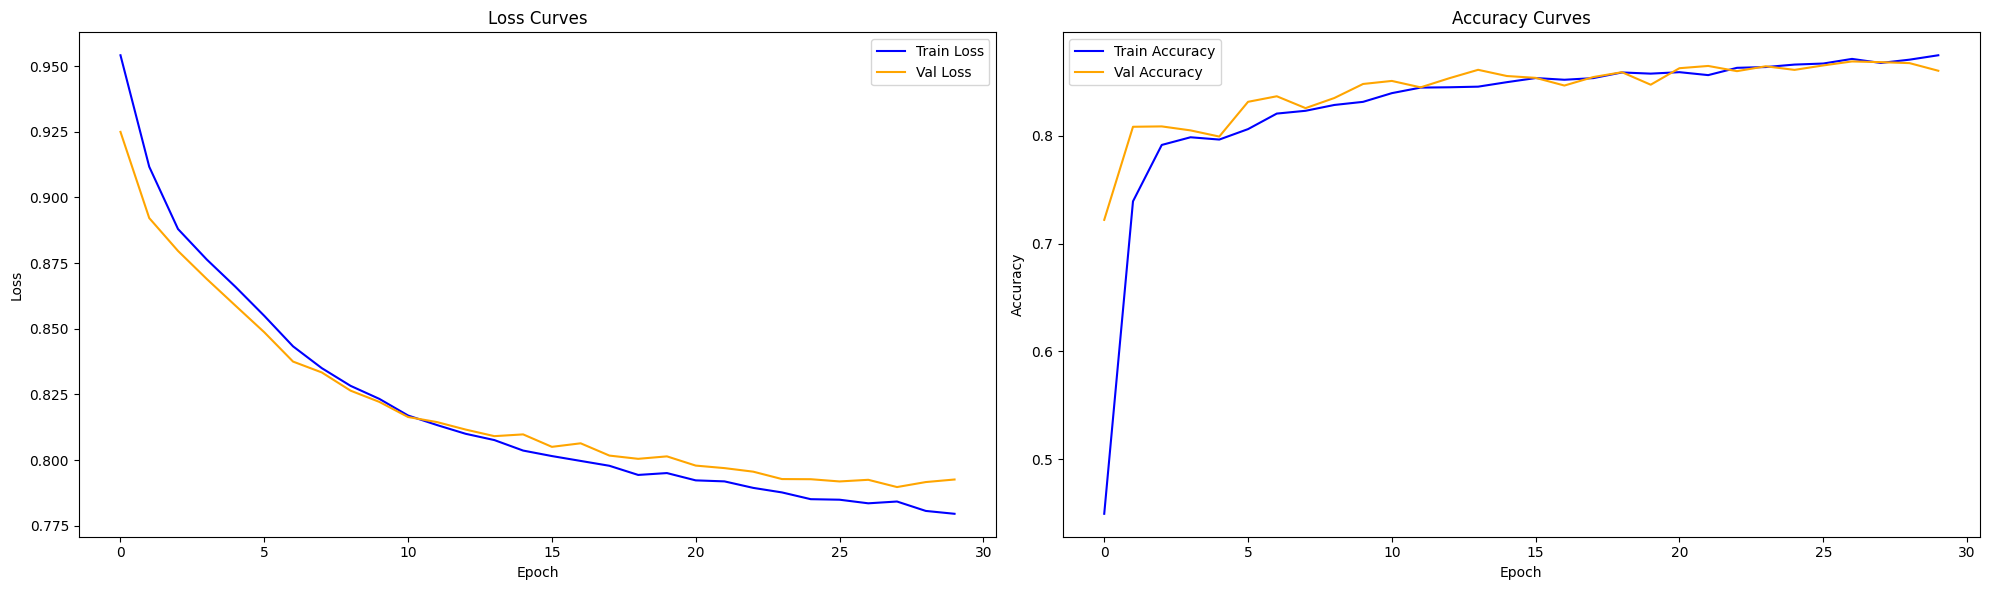

In [ ]:
plot_acc_loss(train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn)

# Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    miou_scores = []
    pixel_accuracies = []
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Compute mIoU
            miou = jaccard_score(masks.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), average='macro')
            miou_scores.append(miou)

            # Compute Pixel Accuracy
            pixel_acc = (predictions == masks).sum().item() / (masks.shape[0] * masks.shape[1] * masks.shape[2])
            pixel_accuracies.append(pixel_acc)

            # Collect images, masks, and predictions for visualization
            all_images.append(images.cpu())
            all_masks.append(masks.cpu())
            all_predictions.append(predictions.cpu())

    # Calculate average metrics
    avg_miou = np.mean(miou_scores)
    avg_pixel_acc = np.mean(pixel_accuracies)

    print(f'Average mIoU: {avg_miou:.4f}, Average Pixel Accuracy: {avg_pixel_acc:.4f}')

    # Concatenate all collected tensors
    all_images_tensor = torch.cat(all_images)
    all_masks_tensor = torch.cat(all_masks)
    all_predictions_tensor = torch.cat(all_predictions)

    return avg_miou, avg_pixel_acc, all_images_tensor, all_masks_tensor, all_predictions_tensor


## Average mIoU

In [ ]:
# Evaluate the model and get predictions
avg_miou_fcn, avg_pixel_acc_fcn, images, masks, predictions_fcn = evaluate_model(model_fcn, test_loader)
print(f'Test mIoU on fcn : {avg_miou_fcn:.4f}, Test Pixel Accuracy: {avg_pixel_acc_fcn:.4f}')

Average mIoU: 0.3043, Average Pixel Accuracy: 0.8279
Test mIoU on fcn : 0.3043, Test Pixel Accuracy: 0.8279


## Visualize predictions

In [ ]:
def visualize_predictions(images, masks, predictions, color_mapping, num_images=3):
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}  # Reverse the mapping for easy lookup

    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0))  # Assuming images are in CHW format
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask (RGB)
        plt.subplot(1, 3, 2)
        gt_mask_rgb = class_to_rgb(masks[i].numpy(), reverse_color_mapping)
        plt.imshow(gt_mask_rgb)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask (RGB)
        plt.subplot(1, 3, 3)
        pred_mask_rgb = class_to_rgb(predictions[i].numpy(), reverse_color_mapping)
        plt.imshow(pred_mask_rgb)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()



In [ ]:
def class_to_rgb(mask, reverse_color_mapping):
    """Convert class indices to RGB values using the reverse color mapping."""
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, rgb in reverse_color_mapping.items():
        rgb_mask[mask == class_idx] = rgb

    return rgb_mask

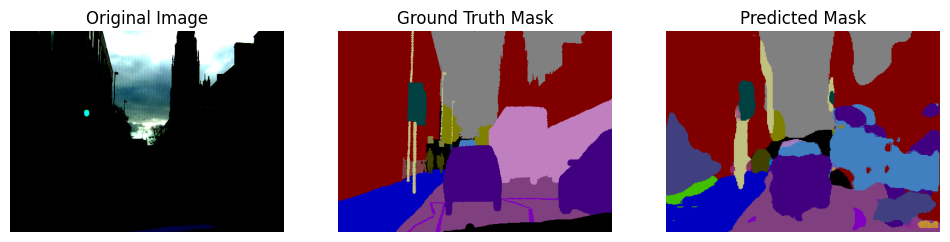

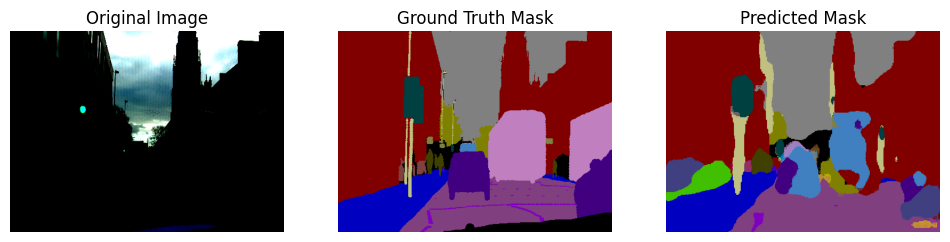

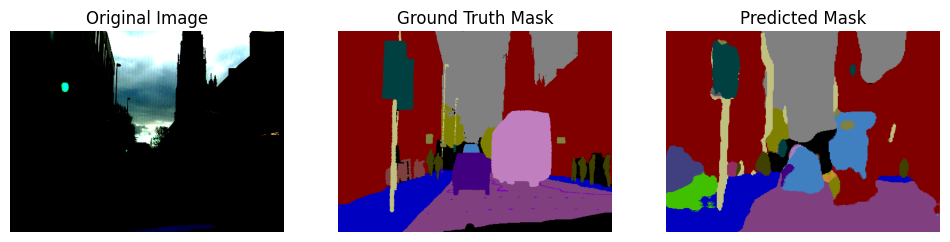

In [ ]:
visualize_predictions(images, masks, predictions_fcn, color_mapping, num_images=3)